# Vigilant Asset Allocation (VAA)

Vigilant Asset Allocation (VAA) is introduced by Wouter J. Keller and Jan Willem Keuning in research paper "Breadth Momentum and Vigilant Asset Allocation (VAA): Winning More by Losing Less" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3002624)

VAA strategy is an upgraded version of dual momentum with fast filter. 

1. We buy the strongest asset in terms of momentum in offensive assets.
2. If the most recent return of any of the offensive assets is negative, we go to defensive asset.

When it comes to computing returns' weights, it emphasizes the most recent 1 month return.

recent_return = 12 * (recent 1M return) + 4 * (recent 4M return) + 2 * (recent 6M return) + 1 * (recent 12M return)

In [1]:
import numpy as np
import pandas as pd
import src.fmp as fmp
import datetime as dt
import matplotlib.pyplot as plt

## Portfolio Assets

In [2]:
offensive = ['SPY', 'VEA', 'VWO', 'AGG']
defensive = ['SHY', 'IEF', 'LQD']

## Calculate monthly prices of offensive assets

In [3]:
offensive_monthly = pd.DataFrame()

for symbol in offensive:
    offensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]
offensive_monthly.dropna(inplace=True)
offensive_monthly.tail(20)

1993-03-31 00:00:00
1993-04-30 00:00:00
1993-06-30 00:00:00
1993-08-31 00:00:00
1993-09-30 00:00:00
1993-11-30 00:00:00
1993-12-31 00:00:00
1994-01-31 00:00:00
1994-02-28 00:00:00
1994-03-31 00:00:00
1994-05-31 00:00:00
1994-06-30 00:00:00
1994-08-31 00:00:00
1994-09-30 00:00:00
1994-10-31 00:00:00
1994-11-30 00:00:00
1995-01-31 00:00:00
1995-02-28 00:00:00
1995-03-31 00:00:00
1995-05-31 00:00:00
1995-06-30 00:00:00
1995-07-31 00:00:00
1995-08-31 00:00:00
1995-10-31 00:00:00
1995-11-30 00:00:00
1996-01-31 00:00:00
1996-02-29 00:00:00
1996-04-30 00:00:00
1996-05-31 00:00:00
1996-07-31 00:00:00
1996-09-30 00:00:00
1996-10-31 00:00:00
1996-12-31 00:00:00
1997-01-31 00:00:00
1997-02-28 00:00:00
1997-03-31 00:00:00
1997-04-30 00:00:00
1997-06-30 00:00:00
1997-07-31 00:00:00
1997-09-30 00:00:00
1997-10-31 00:00:00
1997-12-31 00:00:00
1998-03-31 00:00:00
1998-04-30 00:00:00
1998-06-30 00:00:00
1998-07-31 00:00:00
1998-08-31 00:00:00
1998-09-30 00:00:00
1998-11-30 00:00:00
1998-12-31 00:00:00


2003-09-30 00:00:00
2003-10-31 00:00:00
2003-12-31 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-06-30 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00
2007-04-30 00:00:00
2007-05-31 00:00:00
2007-07-31 00:00:00
2007-08-31 00:00:00
2007-10-31 00:00:00
2007-11-30 00:00:00
2007-12-31 00:00:00
2008-01-31 00:00:00
2008-02-29 00:00:00
2008-03-31 00:00:00
2008-04-30 00:00:00
2008-06-30 00:00:00
2008-07-31 00:00:00
2008-09-30 00:00:00
2008-10-31 00:00:00
2008-12-31 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00


,SPY,VEA,VWO,AGG
2019-04-30,294.019989,42.029999,43.410000,108.589996
2019-05-31,275.269989,39.840000,40.639999,110.400002
2019-07-31,297.429993,40.860001,41.759998,111.300003
2019-09-30,296.769989,41.080002,40.259998,113.169998
2019-10-31,303.329987,42.400002,41.849998,113.150002
2019-12-31,321.859985,44.060001,44.470001,112.370003
2020-01-31,321.730011,42.740002,42.009998,114.650002
2020-03-31,257.750000,33.340000,33.549999,115.370003
2020-04-30,290.480011,35.680000,36.169998,117.099998
2020-06-30,308.359985,38.790001,39.610001,118.209999


## Offensive assets momentum

In [4]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in offensive_monthly.columns:
    print(symbol)
    curr = offensive_monthly[symbol][-1]
    print(curr)
    print(offensive_monthly[symbol].shift(1)[-1])
    m1_ret = (curr - offensive_monthly[symbol].shift(1)[-1]) / offensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    print(m1_ret)
    m3_ret = (curr - offensive_monthly[symbol].shift(3)[-1]) / offensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - offensive_monthly[symbol].shift(6)[-1]) / offensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - offensive_monthly[symbol].shift(12)[-1]) / offensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SPY
429.14
451.56
-0.049650101869076126
VEA
50.49
52.46
-0.03755242089210825
VWO
50.01
52.23
-0.04250430786904076
AGG
114.83
116.06
-0.01059796656901606


In [5]:
offensive_momentum = pd.DataFrame(momentum_data, index=offensive)
offensive_momentum['Score'] = 12 * offensive_momentum['1M'] + 4 * offensive_momentum['3M'] + 2 * offensive_momentum['6M'] + 1 * offensive_momentum['12M']
offensive_momentum

,1M,3M,6M,12M,Score
SPY,-0.049650,0.028373,0.185273,0.664947,0.553183
VEA,-0.037552,-0.002371,0.119760,0.514397,0.293805
VWO,-0.042504,-0.056059,0.051514,0.490611,-0.140648
AGG,-0.010598,0.002970,-0.030316,-0.004681,-0.180609


## Defensive Assets Momentum

In [6]:
defensive_monthly = pd.DataFrame()

for symbol in defensive:
    defensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]
defensive_monthly

2002-07-31 00:00:00
2002-09-30 00:00:00
2002-10-31 00:00:00
2002-12-31 00:00:00
2003-01-31 00:00:00
2003-02-28 00:00:00
2003-03-31 00:00:00
2003-04-30 00:00:00
2003-06-30 00:00:00
2003-07-31 00:00:00
2003-09-30 00:00:00
2003-10-31 00:00:00
2003-12-31 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-06-30 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00
2007-04-30 00:00:00
2007-05-31 00:00:00
2007-07-31 00:00:00
2007-08-31 00:00:00
2007-10-31 00:00:00
2007-11-30 00:00:00
2007-12-31 00:00:00
2008-01-31 00:00:00
2008-02-29 00:00:00
2008-03-31 00:00:00


2014-07-31 00:00:00
2014-09-30 00:00:00
2014-10-31 00:00:00
2014-12-31 00:00:00
2015-03-31 00:00:00
2015-04-30 00:00:00
2015-06-30 00:00:00
2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-07-31 00:00:00
2019-09-30 00:00:00
2019-10-31 00:00:00
2019-12-31 00:00:00
2020-01-31 00:00:00
2020-03-31 00:00:00
2020-04-30 00:00:00
2020-06-30 00:00:00


,SHY,IEF,LQD
2002-07-31,81.260002,82.519997,101.989998
2002-09-30,82.080002,87.559998,107.349998
2002-10-31,82.160004,86.209999,106.250000
2002-12-31,82.309998,86.150002,109.690002
2003-01-31,82.250000,85.489998,108.800003
...,...,...,...
2021-03-31,86.250000,112.930000,130.050003
2021-04-30,86.279999,113.989998,131.150000
2021-06-30,86.160004,115.489998,134.360000
2021-08-31,86.250000,117.170000,135.300000


In [7]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in defensive_monthly.columns:
    print(symbol)
    curr = defensive_monthly[symbol][-1]
    m1_ret = (curr - defensive_monthly[symbol].shift(1)[-1]) / defensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - defensive_monthly[symbol].shift(3)[-1]) / defensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - defensive_monthly[symbol].shift(6)[-1]) / defensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - defensive_monthly[symbol].shift(12)[-1]) / defensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SHY
IEF
LQD


In [8]:
defensive_momentum = pd.DataFrame(momentum_data, index=defensive)
defensive_momentum['Score'] = 12 * defensive_momentum['1M'] + 4 * defensive_momentum['3M'] + 2 * defensive_momentum['6M'] + 1 * defensive_momentum['12M']

## Backtesting

### VAA (Original Version: Offensive + Defensive)

#### Trading Logics

1. Compute vaa_momentum_scores using the function vaa_returns below.
2. If the momentum scores of all offensive assets are positive, we invest in one of the offensive assets which has the largest momentum score.
3. If any of momentum scores of offensive assets is negative, we don't invest in an offensive asset, and look at defensive assets.
4. If the momentum scores of all defensive assets are positive, we invest in one of the defensive assets which has the largest momentum score.
5. If any of momentum scores of defensive assets is negative, we don't inveset in a defensive asset, and hold cash for that month.

In [9]:
def vaa_returns(x):
    m1 = x / x.shift(1) - 1
    m3 = x / x.shift(3) - 1
    m6 = x / x.shift(6) - 1
    m12 = x / x.shift(12) - 1
    return (12 * m1 + 4 * m3 + 2 * m6 + 1 * m12) / 4

In [10]:
vaa_assets = ['SPY', 'VEA', 'VWO', 'AGG', 'SHY', 'IEF', 'LQD']
vaa_monthly_prices = pd.DataFrame()

for asset in vaa_assets:
    vaa_monthly_prices[asset] = fmp.get_monthly_prices(asset)[asset]
vaa_monthly_prices.head(10)

1993-03-31 00:00:00
1993-04-30 00:00:00
1993-06-30 00:00:00
1993-08-31 00:00:00
1993-09-30 00:00:00
1993-11-30 00:00:00
1993-12-31 00:00:00
1994-01-31 00:00:00
1994-02-28 00:00:00
1994-03-31 00:00:00
1994-05-31 00:00:00
1994-06-30 00:00:00
1994-08-31 00:00:00
1994-09-30 00:00:00
1994-10-31 00:00:00
1994-11-30 00:00:00
1995-01-31 00:00:00
1995-02-28 00:00:00
1995-03-31 00:00:00
1995-05-31 00:00:00
1995-06-30 00:00:00
1995-07-31 00:00:00
1995-08-31 00:00:00
1995-10-31 00:00:00
1995-11-30 00:00:00
1996-01-31 00:00:00
1996-02-29 00:00:00
1996-04-30 00:00:00
1996-05-31 00:00:00
1996-07-31 00:00:00
1996-09-30 00:00:00
1996-10-31 00:00:00
1996-12-31 00:00:00
1997-01-31 00:00:00
1997-02-28 00:00:00
1997-03-31 00:00:00
1997-04-30 00:00:00
1997-06-30 00:00:00
1997-07-31 00:00:00
1997-09-30 00:00:00
1997-10-31 00:00:00
1997-12-31 00:00:00
1998-03-31 00:00:00
1998-04-30 00:00:00
1998-06-30 00:00:00
1998-07-31 00:00:00
1998-08-31 00:00:00
1998-09-30 00:00:00
1998-11-30 00:00:00
1998-12-31 00:00:00


2015-03-31 00:00:00
2015-04-30 00:00:00
2015-06-30 00:00:00
2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-07-31 00:00:00
2019-09-30 00:00:00
2019-10-31 00:00:00
2019-12-31 00:00:00
2020-01-31 00:00:00
2020-03-31 00:00:00
2020-04-30 00:00:00
2020-06-30 00:00:00
2020-07-31 00:00:00
2020-08-31 00:00:00
2020-09-30 00:00:00
2020-11-30 00:00:00


2008-02-29 00:00:00
2008-03-31 00:00:00
2008-04-30 00:00:00
2008-06-30 00:00:00
2008-07-31 00:00:00
2008-09-30 00:00:00
2008-10-31 00:00:00
2008-12-31 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00
2010-03-31 00:00:00
2010-04-30 00:00:00
2010-06-30 00:00:00
2010-08-31 00:00:00
2010-09-30 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-31 00:00:00
2011-02-28 00:00:00
2011-03-31 00:00:00
2011-05-31 00:00:00
2011-06-30 00:00:00
2011-08-31 00:00:00
2011-09-30 00:00:00
2011-10-31 00:00:00
2011-11-30 00:00:00
2012-01-31 00:00:00
2012-02-29 00:00:00
2012-04-30 00:00:00
2012-05-31 00:00:00
2012-07-31 00:00:00
2012-08-31 00:00:00
2012-10-31 00:00:00
2012-11-30 00:00:00
2012-12-31 00:00:00
2013-01-31 00:00:00
2013-02-28 00:00:00
2013-04-30 00:00:00
2013-05-31 00:00:00
2013-07-31 00:00:00
2013-09-30 00:00:00
2013-10-31 00:00:00
2013-12-31 00:00:00
2014-01-31 00:00:00


,SPY,VEA,VWO,AGG,SHY,IEF,LQD
1993-03-31,45.18750,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-30,44.03125,NaN,NaN,NaN,NaN,NaN,NaN
1993-06-30,45.06250,NaN,NaN,NaN,NaN,NaN,NaN
1993-08-31,46.56250,NaN,NaN,NaN,NaN,NaN,NaN
1993-09-30,45.93750,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-30,46.34375,NaN,NaN,NaN,NaN,NaN,NaN
1993-12-31,46.59375,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-31,48.21875,NaN,NaN,NaN,NaN,NaN,NaN
1994-02-28,46.81250,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-31,44.59375,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
vaa_monthly_mom = vaa_monthly_prices.copy()
vaa_monthly_mom = vaa_monthly_mom.apply(vaa_returns, axis=0)
vaa_monthly_mom.dropna(inplace=True)

In [12]:
for date in vaa_monthly_mom.index:
    if (vaa_monthly_mom.loc[date,['SPY', 'VEA', 'VWO', 'AGG']] < 0).any():
        # check defensive assets
        vaa_monthly_mom.loc[date, 'SPY'] = 0
        vaa_monthly_mom.loc[date, 'VEA'] = 0
        vaa_monthly_mom.loc[date, 'VWO'] = 0
        vaa_monthly_mom.loc[date, 'AGG'] = 0
        if (vaa_monthly_mom.loc[date,['SHY', 'IEF', 'LQD']] < 0).any():
            # hold cash
            vaa_monthly_mom.loc[date, 'SHY'] = 0
            vaa_monthly_mom.loc[date, 'IEF'] = 0
            vaa_monthly_mom.loc[date, 'LQD'] = 0
    else:
        # invest offensive asset
        vaa_monthly_mom.loc[date, 'SHY'] = 0
        vaa_monthly_mom.loc[date, 'IEF'] = 0
        vaa_monthly_mom.loc[date, 'LQD'] = 0
vaa_monthly_mom

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2008-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-12-31,0.000000,0.000000,0.000000,0.000000,0.049424,0.558587,0.456708
2009-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-08-31,0.579126,0.321126,0.053336,0.033184,0.000000,0.000000,0.000000


In [13]:
mom_rank = vaa_monthly_mom.rank(axis=1, ascending=False)
for symbol in mom_rank.columns:
    mom_rank[symbol] = np.where(mom_rank[symbol] == 1, 1, 0)
mom_rank

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2008-10-31,0,0,0,0,0,0,0
2008-12-31,0,0,0,0,0,1,0
2009-03-31,0,0,0,0,0,0,0
2009-04-30,0,0,0,0,0,0,0
2009-06-30,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2021-03-31,0,0,0,0,0,0,0
2021-04-30,0,0,0,0,0,0,0
2021-06-30,0,0,0,0,0,0,0
2021-08-31,1,0,0,0,0,0,0


In [14]:
# we have to shift the returns upward by one to align with momentum signal above.
vaa_monthly_rets = vaa_monthly_prices.pct_change()
vaa_monthly_rets.dropna(inplace=True)
vaa_monthly_rets = vaa_monthly_rets[mom_rank.index[0]:].shift(-1)
vaa_monthly_rets

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2008-10-31,-0.068057,-0.016822,-0.065054,0.085869,0.005463,0.121060,0.159726
2008-12-31,-0.118794,-0.162359,-0.000424,-0.026200,-0.004016,-0.019689,-0.074078
2009-03-31,0.099346,0.118209,0.174448,0.001675,-0.003321,-0.030231,0.022099
2009-04-30,0.051819,0.109988,0.149982,0.005018,-0.003927,-0.032027,0.042412
2009-06-30,0.074606,0.105742,0.109051,0.009300,-0.000239,0.005515,0.041683
...,...,...,...,...,...,...,...
2021-03-31,0.052910,0.030544,0.017867,0.005798,0.000348,0.009386,0.008458
2021-04-30,0.025785,0.017981,0.025104,0.007337,-0.001391,0.013159,0.024476
2021-06-30,0.054899,0.018245,-0.038299,0.006330,0.001045,0.014547,0.006996
2021-08-31,-0.049650,-0.037552,-0.042504,-0.010598,-0.001159,-0.016642,-0.016778


In [15]:
vaa_port = np.multiply(mom_rank, vaa_monthly_rets)
vaa_port_returns = vaa_port.sum(axis=1)
vaa_port_cum_returns = np.exp(np.log1p(vaa_port_returns).cumsum())[:-1]

### VAA (Modified: Relative Momentum Offensive Only)

#### Trading Logics

1. In this case, we only consider offensive assets.
2. Once we calculate momentum scores of offensive assets, and pick the one which has the largest score.
3. We are always invested in the market as we have to pick one offensive asset every month.

In [16]:
offensive_monthly_mom = offensive_monthly.copy()
offensive_monthly_mom = offensive_monthly_mom.apply(vaa_returns, axis=0)
offensive_monthly_mom.dropna(inplace=True)

# print(offensive_monthly_mom)

off_mom_rank = offensive_monthly_mom.rank(axis=1, ascending=False)
for symbol in off_mom_rank.columns:
    off_mom_rank[symbol] = np.where(off_mom_rank[symbol] < 2, 1, 0)
    
print(off_mom_rank)
    
offensive_monthly_rets = offensive_monthly.pct_change()
offensive_monthly_rets.dropna(inplace=True)
offensive_monthly_rets = offensive_monthly_rets[off_mom_rank.index[0]:].shift(-1)

offensive_port = np.multiply(off_mom_rank, offensive_monthly_rets)
offensive_port_returns = offensive_port.sum(axis=1)
offensive_port_cum_returns = np.exp(np.log1p(offensive_port_returns).cumsum())[:-1]
offensive_port_cum_returns.tail()

            SPY  VEA  VWO  AGG
2008-10-31    0    0    0    1
2008-12-31    0    0    0    1
2009-03-31    0    0    0    1
2009-04-30    0    0    1    0
2009-06-30    0    0    1    0
...         ...  ...  ...  ...
2021-03-31    1    0    0    0
2021-04-30    1    0    0    0
2021-06-30    1    0    0    0
2021-08-31    1    0    0    0
2021-09-30    1    0    0    0

[108 rows x 4 columns]


2020-12-31    2.096039
2021-03-31    2.206941
2021-04-30    2.263847
2021-06-30    2.388130
2021-08-31    2.269559
dtype: float64

### VAA (Modified: Dual momentum Offensive Only)

#### Trading Logics

1. In this case, we also consider only offensive assets like the previous case.
2. Once we calculate momentum scores of offensive assets, and we apply absolute momentum by checking the signs of momentum scores.
3. If any of the momentum scores of offensive assets is negative, we don't invest in any offensive asset, and hold cash for that month.

In [17]:
dual_offensive_monthly_mom = offensive_monthly.copy()
dual_offensive_monthly_mom = dual_offensive_monthly_mom.apply(vaa_returns, axis=0)
dual_offensive_monthly_mom.dropna(inplace=True)

print(dual_offensive_monthly_mom)

for date in dual_offensive_monthly_mom.index:
    if (dual_offensive_monthly_mom.loc[date] < 0).any():
        # print(date, ' negative')
        # check defensive assets
        dual_offensive_monthly_mom.loc[date, 'SPY'] = 0
        dual_offensive_monthly_mom.loc[date, 'VEA'] = 0
        dual_offensive_monthly_mom.loc[date, 'VWO'] = 0
        dual_offensive_monthly_mom.loc[date, 'AGG'] = 0

print(dual_offensive_monthly_mom)

dual_off_mom_rank = dual_offensive_monthly_mom.rank(axis=1, ascending=False)

print(dual_off_mom_rank)
for symbol in dual_off_mom_rank.columns:
    dual_off_mom_rank[symbol] = np.where(dual_off_mom_rank[symbol] == 1, 1, 0)
    
dual_offensive_monthly_rets = offensive_monthly.pct_change()
dual_offensive_monthly_rets.dropna(inplace=True)
dual_offensive_monthly_rets = dual_offensive_monthly_rets[dual_off_mom_rank.index[0]:].shift(-1)

dual_offensive_port = np.multiply(dual_off_mom_rank, dual_offensive_monthly_rets)
dual_offensive_port_returns = dual_offensive_port.sum(axis=1)
dual_offensive_port_cum_returns = np.exp(np.log1p(dual_offensive_port_returns).cumsum())[:-1]
dual_offensive_port_cum_returns

                 SPY       VEA       VWO       AGG
2008-10-31 -0.961042 -1.252061 -1.637638 -0.165762
2008-12-31 -0.747917 -0.682495 -1.041180  0.313724
2009-03-31 -1.004684 -1.225276 -0.740012 -0.052757
2009-04-30 -0.060591 -0.047141  0.295506  0.069510
2009-06-30 -0.055879  0.113237  0.559314  0.006466
...              ...       ...       ...       ...
2021-03-31  0.590112  0.503363  0.550133 -0.163567
2021-04-30  0.544246  0.398105  0.349954 -0.034035
2021-06-30  0.417479  0.302802  0.328951 -0.008443
2021-08-31  0.579126  0.321126  0.053336  0.033184
2021-09-30  0.138296  0.073451 -0.035162 -0.045152

[108 rows x 4 columns]
                 SPY       VEA       VWO       AGG
2008-10-31  0.000000  0.000000  0.000000  0.000000
2008-12-31  0.000000  0.000000  0.000000  0.000000
2009-03-31  0.000000  0.000000  0.000000  0.000000
2009-04-30  0.000000  0.000000  0.000000  0.000000
2009-06-30  0.000000  0.000000  0.000000  0.000000
...              ...       ...       ...       ...
2021-03

2008-10-31    1.000000
2008-12-31    1.000000
2009-03-31    1.000000
2009-04-30    1.000000
2009-06-30    1.000000
                ...   
2020-12-31    1.654931
2021-03-31    1.654931
2021-04-30    1.654931
2021-06-30    1.654931
2021-08-31    1.572764
Length: 107, dtype: float64

### 60/40 Benchmark

In [18]:
assets = ['BND', 'SPY']

sixtyForty = pd.DataFrame()

for symbol in assets:
    sixtyForty[symbol] = fmp.get_monthly_prices(symbol)[symbol]

2007-04-30 00:00:00
2007-05-31 00:00:00
2007-07-31 00:00:00
2007-08-31 00:00:00
2007-10-31 00:00:00
2007-11-30 00:00:00
2007-12-31 00:00:00
2008-01-31 00:00:00
2008-02-29 00:00:00
2008-03-31 00:00:00
2008-04-30 00:00:00
2008-06-30 00:00:00
2008-07-31 00:00:00
2008-09-30 00:00:00
2008-10-31 00:00:00
2008-12-31 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00
2010-03-31 00:00:00
2010-04-30 00:00:00
2010-06-30 00:00:00
2010-08-31 00:00:00
2010-09-30 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-31 00:00:00
2011-02-28 00:00:00
2011-03-31 00:00:00
2011-05-31 00:00:00
2011-06-30 00:00:00
2011-08-31 00:00:00
2011-09-30 00:00:00
2011-10-31 00:00:00
2011-11-30 00:00:00
2012-01-31 00:00:00
2012-02-29 00:00:00
2012-04-30 00:00:00
2012-05-31 00:00:00
2012-07-31 00:00:00
2012-08-31 00:00:00
2012-10-31 00:00:00
2012-11-30 00:00:00
2012-12-31 00:00:00
2013-01-31 00:00:00


In [19]:
sixtyForty_returns = sixtyForty.pct_change()
sixtyForty_returns = sixtyForty_returns[mom_rank.index[0]:].shift(-1)
sixtyForty_weights = np.array([0.4, 0.6])
sixtyForty_returns['port'] = sixtyForty_returns.dot(sixtyForty_weights)
sixtyForty_returns.tail()

,BND,SPY,port
2021-03-31,0.006374,0.052910,0.034296
2021-04-30,0.007389,0.025785,0.018427
2021-06-30,0.006636,0.054899,0.035594
2021-08-31,-0.011682,-0.049650,-0.034463
2021-09-30,NaN,NaN,NaN


In [20]:
sixtyForty_cum_returns = np.exp(np.log1p(sixtyForty_returns['port']).cumsum())[:-1]
sixtyForty_cum_returns.tail()

2020-12-31    2.569463
2021-03-31    2.657585
2021-04-30    2.706555
2021-06-30    2.802892
2021-08-31    2.706297
Name: port, dtype: float64

### SPY (S&P 500)

In [21]:
benchmark_prices = fmp.get_monthly_prices('SPY')
benchmark_returns = benchmark_prices.pct_change()
benchmark_returns = benchmark_returns[mom_rank.index[0]:].shift(-1)
benchmark_cum_returns = np.exp(np.log1p(benchmark_returns).cumsum())[:-1]
benchmark_cum_returns.tail()

1993-03-31 00:00:00
1993-04-30 00:00:00
1993-06-30 00:00:00
1993-08-31 00:00:00
1993-09-30 00:00:00
1993-11-30 00:00:00
1993-12-31 00:00:00
1994-01-31 00:00:00
1994-02-28 00:00:00
1994-03-31 00:00:00
1994-05-31 00:00:00
1994-06-30 00:00:00
1994-08-31 00:00:00
1994-09-30 00:00:00
1994-10-31 00:00:00
1994-11-30 00:00:00
1995-01-31 00:00:00
1995-02-28 00:00:00
1995-03-31 00:00:00
1995-05-31 00:00:00
1995-06-30 00:00:00
1995-07-31 00:00:00
1995-08-31 00:00:00
1995-10-31 00:00:00
1995-11-30 00:00:00
1996-01-31 00:00:00
1996-02-29 00:00:00
1996-04-30 00:00:00
1996-05-31 00:00:00
1996-07-31 00:00:00
1996-09-30 00:00:00
1996-10-31 00:00:00
1996-12-31 00:00:00
1997-01-31 00:00:00
1997-02-28 00:00:00
1997-03-31 00:00:00
1997-04-30 00:00:00
1997-06-30 00:00:00
1997-07-31 00:00:00
1997-09-30 00:00:00
1997-10-31 00:00:00
1997-12-31 00:00:00
1998-03-31 00:00:00
1998-04-30 00:00:00
1998-06-30 00:00:00
1998-07-31 00:00:00
1998-08-31 00:00:00
1998-09-30 00:00:00
1998-11-30 00:00:00
1998-12-31 00:00:00


,SPY
2020-12-31,4.093049
2021-03-31,4.309615
2021-04-30,4.420737
2021-06-30,4.663431
2021-08-31,4.431891


In [22]:
combined_df = pd.DataFrame()
combined_df['VAA/Original'] = vaa_port_cum_returns
combined_df['VAA/Relative_Offensive'] = offensive_port_cum_returns
combined_df['VAA/Dual_Offensive'] = dual_offensive_port_cum_returns
combined_df['60/40'] = sixtyForty_cum_returns
combined_df['SPY'] = benchmark_cum_returns
combined_df.iloc[0] = 1
combined_df.index = pd.to_datetime(combined_df.index)
combined_df

,VAA/Original,VAA/Relative_Offensive,VAA/Dual_Offensive,60/40,SPY
2008-10-31,1.000000,1.000000,1.000000,1.000000,1.000000
2008-12-31,0.980311,1.057420,1.000000,0.911329,0.821233
2009-03-31,0.980311,1.059191,1.000000,0.966029,0.902819
2009-04-30,0.980311,1.218051,1.000000,0.998366,0.949602
2009-06-30,0.980311,1.350880,1.000000,1.046911,1.020448
...,...,...,...,...,...
2020-12-31,1.843084,2.096039,1.654931,2.569463,4.093049
2021-03-31,1.843084,2.206941,1.654931,2.657585,4.309615
2021-04-30,1.843084,2.263847,1.654931,2.706555,4.420737
2021-06-30,1.843084,2.388130,1.654931,2.802892,4.663431


In [23]:
stats_summary = pd.DataFrame(columns = ['Portfolio', 'CAGR (%)', 'MDD (%)', 'CAGR/MDD'])
beginning_month = combined_df.index[0].year

for col in combined_df.columns:
    # compute CAGR
    first_value = combined_df[col][0]
    last_value = combined_df[col][-1]  
    years = len(combined_df[col].index)/12    
    cagr = (last_value/first_value)**(1/years) - 1
    
    # compute MDD
    cumulative_returns = combined_df[col]
    previous_peaks = cumulative_returns.cummax()
    drawdown = (cumulative_returns - previous_peaks) / previous_peaks
    portfolio_mdd = drawdown.min()
    
    # save CAGR and MDD for each portfolio    
    stats_summary = stats_summary.append({'Portfolio': col,
                                         'CAGR (%)': cagr * 100,
                                         'MDD (%)': portfolio_mdd * 100,
                                         'CAGR/MDD': abs(cagr / portfolio_mdd).round(2)}, ignore_index=True) 

In [24]:
stats_summary.set_index('Portfolio', inplace=True)
stats_summary.sort_values('CAGR/MDD', ascending=False, inplace=True)
stats_summary

,CAGR (%),MDD (%),CAGR/MDD
Portfolio,,,
60/40,11.812589,-12.011259,0.98
SPY,18.172020,-19.918594,0.91
VAA/Original,6.487938,-10.406886,0.62
VAA/Dual_Offensive,5.209684,-11.920743,0.44
VAA/Relative_Offensive,9.627287,-29.997484,0.32


### Backtesting Performance Comparison (All Portfolios)

Text(0.5, 1.0, 'Portfolio Performance Comparison')

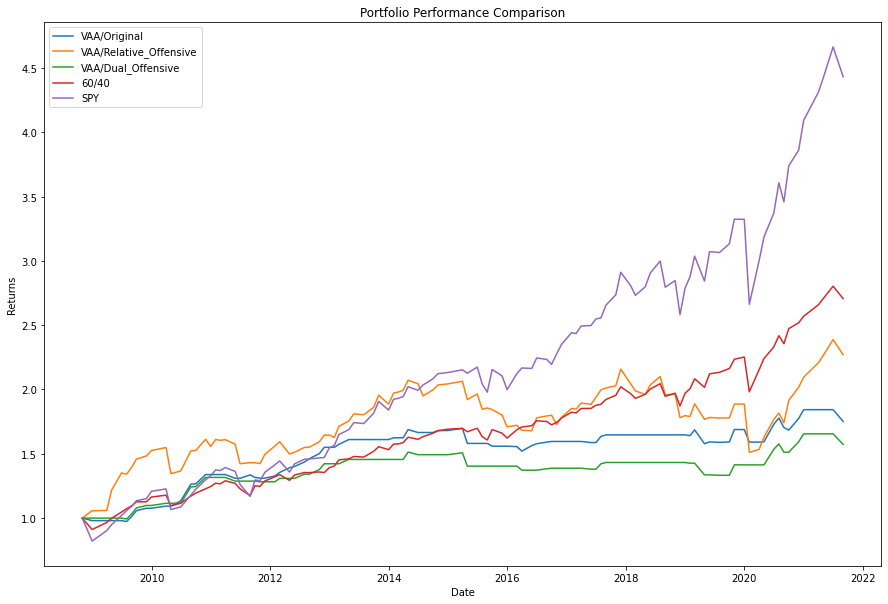

In [25]:
plt.figure(figsize=(15,10))
plt.plot(combined_df)
plt.legend(combined_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

### Backtesting Performance Comparison (Original VAA, 60/40, SPY)

Text(0.5, 1.0, 'Portfolio Performance Comparison')

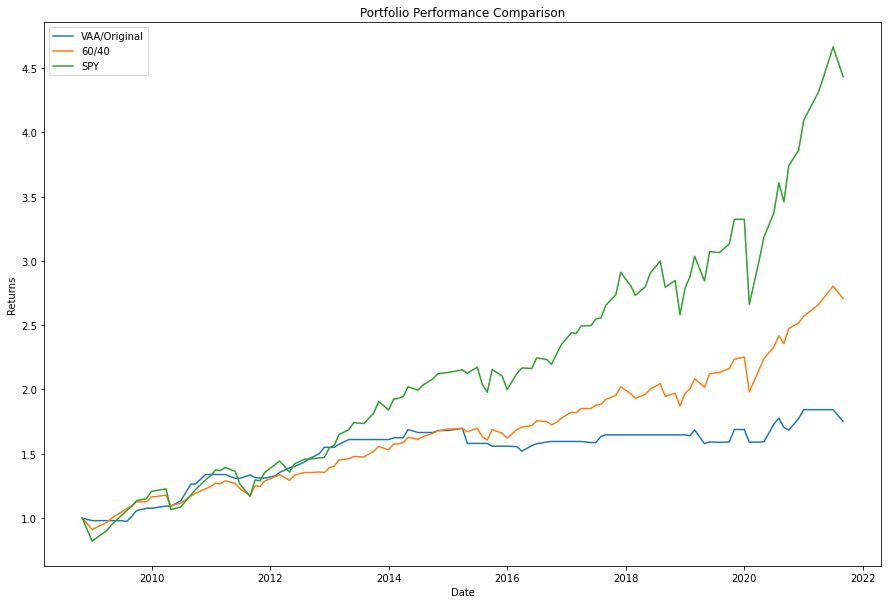

In [26]:
sub_df = combined_df[['VAA/Original', '60/40', 'SPY']]
plt.figure(figsize=(15,10))
plt.plot(sub_df)
plt.legend(sub_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

## Investment decision based on strategy algorithm

In [27]:
offensive_momentum

,1M,3M,6M,12M,Score
SPY,-0.049650,0.028373,0.185273,0.664947,0.553183
VEA,-0.037552,-0.002371,0.119760,0.514397,0.293805
VWO,-0.042504,-0.056059,0.051514,0.490611,-0.140648
AGG,-0.010598,0.002970,-0.030316,-0.004681,-0.180609


In [28]:
defensive_momentum

,1M,3M,6M,12M,Score
SHY,-0.001159,-0.001507,-0.003009,-0.006000,-0.031958
IEF,-0.016642,0.010790,-0.042944,-0.051531,-0.293967
LQD,-0.016778,0.014335,-0.039356,0.077079,-0.145624


In [29]:
if (offensive_momentum['Score'] < 0).any():
    if (defensive_momentum['Score'] < 0).any():
        print('hold cash')
    else:
        first = defensive_momentum.sort_values(by='Score', ascending=False).index[0]
        print('invest in ' + first)
else:
    first = offensive_momentum.sort_values(by='Score', ascending=False).index[0]
    print('invest in ' + first)

hold cash
